In [1]:
from IPython.display import display, SVG
import numpy as np
import os
import pydot
import sys

from pydrake.all import (
    Adder, AddMultibodyPlantSceneGraph, Demultiplexer, DiagramBuilder, 
    InverseDynamicsController, MakeMultibodyStateToWsgStateSystem, 
    MeshcatVisualizerCpp, MultibodyPlant,Parser, PassThrough, RevoluteJoint,
    SchunkWsgPositionController, StateInterpolatorWithDiscreteDerivative, Simulator
)
from manipulation.meshcat_cpp_utils import StartMeshcat
from manipulation.scenarios import AddIiwa, AddWsg, AddRgbdSensors
from manipulation.utils import FindResource
from manipulation import running_as_notebook

if running_as_notebook and sys.platform == "linux" and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()


In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

# Set up a basic ManipulationStation diagram

Completely in pydrake.  Feel free to modify it as you see fit.  You might also look at the [C++ version](https://github.com/RobotLocomotion/drake/blob/master/examples/manipulation_station/manipulation_station.cc#L193) if you want inspiration for tables / cupboards / bins, etc that you might add.  Here is [a link to the scenarios file](https://github.com/RussTedrake/manipulation/blob/master/manipulation/scenarios.py), in case you need to modify `AddIiwa` and friends.

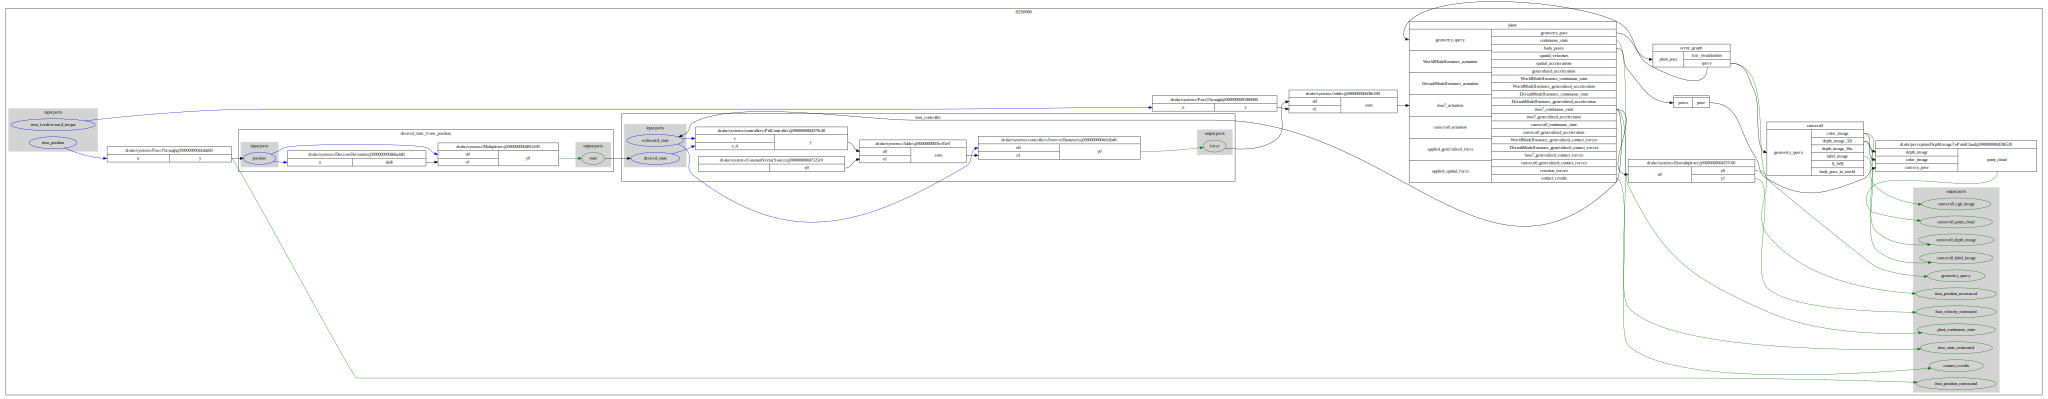

In [3]:

def MakeManipulationStation(time_step=0.002):
    builder = DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)
    iiwa = AddIiwa(plant)
    # wsg = AddWsg(plant, iiwa)
    Parser(plant).AddModelFromFile(
        FindResource("models/camera_box.sdf"), "camera0")
    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa)

    # I need a PassThrough system so that I can export the input port.
    iiwa_position = builder.AddSystem(PassThrough(num_iiwa_positions))
    builder.ExportInput(iiwa_position.get_input_port(), "iiwa_position")
    builder.ExportOutput(iiwa_position.get_output_port(), "iiwa_position_command")

    # Export the iiwa "state" outputs.
    demux = builder.AddSystem(Demultiplexer(
        2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
    builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant = MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant)
    # AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        InverseDynamicsController(
            controller_plant,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=False))
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder = builder.AddSystem(Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(),
                    adder.get_input_port(0))
    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough = builder.AddSystem(PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough.get_output_port(),
                    adder.get_input_port(1))
    builder.ExportInput(torque_passthrough.get_input_port(), 
                        "iiwa_feedforward_torque")
    builder.Connect(adder.get_output_port(),
                    plant.get_actuation_input_port(iiwa))

    # Add discrete derivative to command velocities.
    desired_state_from_position = builder.AddSystem(
        StateInterpolatorWithDiscreteDerivative(
            num_iiwa_positions, time_step, suppress_initial_transient=True))
    desired_state_from_position.set_name("desired_state_from_position")
    builder.Connect(desired_state_from_position.get_output_port(),      
                    iiwa_controller.get_input_port_desired_state())
    builder.Connect(iiwa_position.get_output_port(), 
                    desired_state_from_position.get_input_port())

    # Export commanded torques.
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_commanded")
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_measured")

    # # Wsg controller.
    # wsg_controller = builder.AddSystem(SchunkWsgPositionController())
    # wsg_controller.set_name("wsg_controller")
    # builder.Connect(
    #     wsg_controller.get_generalized_force_output_port(),             
    #     plant.get_actuation_input_port(wsg))
    # builder.Connect(plant.get_state_output_port(wsg),
    #                 wsg_controller.get_state_input_port())
    # builder.ExportInput(wsg_controller.get_desired_position_input_port(), 
    #                     "wsg_position")
    # builder.ExportInput(wsg_controller.get_force_limit_input_port(),  
    #                     "wsg_force_limit")
    # wsg_mbp_state_to_wsg_state = builder.AddSystem(
    #     MakeMultibodyStateToWsgStateSystem())
    # builder.Connect(plant.get_state_output_port(wsg), 
    #                 wsg_mbp_state_to_wsg_state.get_input_port())
    # builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(), 
    #                      "wsg_state_measured")
    # builder.ExportOutput(wsg_controller.get_grip_force_output_port(), 
    #                      "wsg_force_measured")

    # Cameras.
    AddRgbdSensors(builder, plant, scene_graph)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "geometry_query")
    builder.ExportOutput(plant.get_contact_results_output_port(), 
                         "contact_results")
    builder.ExportOutput(plant.get_state_output_port(), 
                         "plant_continuous_state")

    diagram = builder.Build()
    return diagram

diagram = MakeManipulationStation()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

In [4]:

def TestWithMeshcat():
    builder = DiagramBuilder()
    station = builder.AddSystem(MakeManipulationStation())

    MeshcatVisualizerCpp.AddToBuilder(
        builder, station.GetOutputPort("geometry_query"), meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

TestWithMeshcat()

In [5]:
builder = DiagramBuilder()
# station_diagram, plant = MakeManipulationStation()
station_diagram = MakeManipulationStation()
station = builder.AddSystem(station_diagram)

MeshcatVisualizerCpp.AddToBuilder(
builder, station.GetOutputPort("geometry_query"), meshcat)

#fix wsg position
# wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
# builder.Connect(wsg_position.get_output_port(),
# station.GetInputPort("wsg_position"))

diagram = builder.Build()

context = diagram.CreateDefaultContext()
diagram.Publish(context)

simulator = Simulator(diagram)
context = simulator.get_mutable_context()
# plant_context = plant.GetMyContextFromRoot(context)

# #initial condition
# plant.SetFreeBodyPose(plant_context, sphere, x_WSphere_throw)
# plant.SetFreeBodySpatialVelocity(context=plant_context, body=sphere, V_WB=v_WB)

simulator.set_target_realtime_rate(0.1)
simulator.AdvanceTo(2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a794b6e2-86ff-40f8-a978-0466e91906a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [6]:
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(0.01)
# simulator.AdvanceTo(0.02)
simulator.AdvanceTo(3)